In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [3]:
img_dim = 28
cats = np.load('data/quickdraw/full_numpy_bitmap_cat.npy').reshape(-1, 1, img_dim, img_dim) / 255
dogs = np.load('data/quickdraw/full_numpy_bitmap_dog.npy').reshape(-1, 1, img_dim, img_dim) / 255

n_cats = cats.shape[0]
# n_dogs = dogs.shape[0]

x = cats  # np.concatenate((cats, dogs))
y = np.ones(n_cats)  # np.concatenate((np.zeros(n_cats), np.ones(n_dogs)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1, shuffle=True, random_state=69)

train_data = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
test_data  = TensorDataset(torch.tensor(x_test).float(),  torch.tensor(y_test).float())

trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data, batch_size=64, shuffle=True)


In [4]:
class CNN(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.encode = nn.Sequential(
            # Convolve
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            # Reshape
            nn.Flatten(1),
            # Linear
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim)
        )
        
        self.decode = nn.Sequential(
            # Linear
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            # Reshape
            nn.Unflatten(1, (32, 3, 3)),
            # Convolve
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [22]:
z_dim = 40
model = CNN(z_dim).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()

n_epochs = 50
losses = []
for epoch in tqdm(range(1, n_epochs+1)):
    batch_losses = []
    for x, _ in trainloader:
        x = x.to(device)
        x_hat = model(x)
        
        loss = loss_fn(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
    

100%|██████████| 50/50 [04:36<00:00,  5.53s/it]


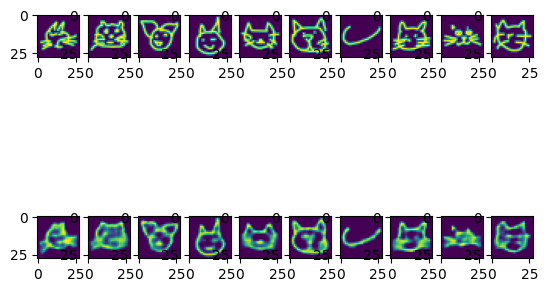

In [23]:
for x, _ in testloader:
    fig, ax = plt.subplots(2, 10)
    x = x.to(device)
    x_hat = model(x).cpu().detach().numpy()

    for n in range(10):
        ax[0][n].imshow(x[n][0].cpu())
        ax[1][n].imshow(x_hat[n][0])

    break

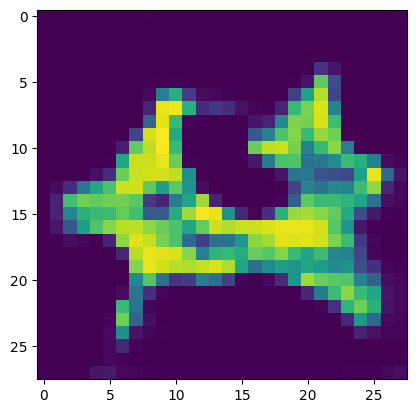

In [39]:
z = torch.randn(1, z_dim).to(device)

plt.imshow(model.decode(z).cpu().detach().numpy()[0][0])